### Cài đặt thư viện

Run these commands in terminal:
- brew install wget

- wget https://github.com/milvus-io/milvus/releases/download/v2.2.11/milvus-standalone-docker-compose.yml -O docker-compose.yml

- docker compose up -d


In [1]:
! pip install fiftyone==0.21.4
! pip install torch torchvision torchaudio
! pip install ipywidgets
! pip install pymilvus
! pip install httpcore==0.17.3
! pip install httpx==0.24.1
! pip install h11==0.14.0

In [2]:
import fiftyone as fo
import fiftyone.brain as fob
import numpy as np
from glob import glob
import json
import os
from pymilvus import Milvus

### Tải dữ liệu

In [3]:
# load dataset
dataset = fo.Dataset.from_images_dir('/Users/duyennguyen/Downloads/AIC/Batch_01/Keyframes', name=None, tags=None, recursive=True)

 100% |█████████████| 87306/87306 [6.9s elapsed, 0s remaining, 12.2K samples/s]      


### Tải lại dữ liệu có sẵn

In [4]:
# # reload dataset from directory if already trained

# # The directory containing the dataset to import
# dataset_dir = "./Milvus_FiftyOne/milvus_index_141023"

# # The type of the dataset being imported
# dataset_type = fo.types.FiftyOneDataset  # for example

# milvus = Milvus(uri='tcp://localhost:19530')

# # Import the dataset
# dataset = fo.Dataset.from_dir(
#     dataset_dir=dataset_dir,
#     dataset_type=dataset_type,
# )

In [5]:
# print(dataset.get_brain_info('milvus_index'))
# milvus_index = dataset.load_brain_results('milvus_index')
# print(milvus_index)

### Kiểm tra dữ liệu đã tải

In [6]:
print(dataset.first())

<Sample: {
    'id': '652bfab47c85f0940c39db6e',
    'media_type': 'image',
    'filepath': '/Users/duyennguyen/Downloads/AIC/Batch_01/Keyframes/Batch_01/keyframes-1/L07_V001/0001.jpg',
    'tags': [],
    'metadata': None,
}>


### Trích xuất thêm thông tin tên của video và frameid
Thông tin `video` và `frameid` sẽ được lấy từ tên của tập tin keyframe.

In [7]:
for sample in dataset:
    _, sample['video'], sample['frameid'] = sample['filepath'][:-4].rsplit('/', 2)
    sample.save()

### Thêm thông tin kết quả của object detection.

In [8]:
for sample in dataset:
    object_path = f"/Users/duyennguyen/Downloads/AIC/Batch_01/objects/{sample['video']}/{sample['frameid']}.json"
    with open(object_path) as jsonfile:
        det_data = json.load(jsonfile)
    detections = []
    for cls, box, score in zip(det_data['detection_class_entities'], det_data['detection_boxes'], det_data['detection_scores']):
        # Convert to [top-left-x, top-left-y, width, height]
        boxf = [float(box[1]), float(box[0]), float(box[3]) - float(box[1]), float(box[2]) - float(box[0])]
        scoref = float(score)

        # Only add objects with confidence > 0.4
        if scoref > 0.4:
            detections.append(
                fo.Detection(
                    label=cls,
                    bounding_box= boxf,
                    confidence=float(score)
                )
            )

    sample["object_faster_rcnn"] = fo.Detections(detections=detections)
    sample.save()

### Thêm thông tin CLIP embedding.

In [9]:
all_keyframe = glob('/Users/duyennguyen/Downloads/AIC/Batch_01/Keyframes/*/keyframes-*/*/*.jpg')
video_keyframe_dict = {}
all_video = glob('/Users/duyennguyen/Downloads/AIC/Batch_01/Keyframes/*/keyframes-*/*')
all_video = [v.rsplit('/',1)[-1] for v in all_video]

Tạo dictionary `video_keyframe_dict` với `video_keyframe_dict[video]` thông tin danh sách `keyframe` của `video`

In [10]:
for kf in all_keyframe:
    _, vid, kf = kf[:-4].rsplit('/',2)
    if vid not in video_keyframe_dict.keys():
        video_keyframe_dict[vid] = [kf]
    else:
        video_keyframe_dict[vid].append(kf)

Do thông tin vector CLIP embedding được cung cấp được lưu theo từng video nhầm mục đích tối ưu thời gian đọc dữ liệu. Cần sort lại danh sách `keyframe` của từng `video` để đảm bảo thứ tự đọc đúng với vector embedding được cung cấp.

In [11]:
for k,v in video_keyframe_dict.items():
    video_keyframe_dict[k] = sorted(v)

Tạo dictionary `embedding_dict` với `embedding_dict[video][keyframe]` lưu thông tin vector CLIP embedding của `keyframe` trong `video` tương ứng

In [12]:
embedding_dict = {}
for v in all_video:
    clip_path = f'/Users/duyennguyen/Downloads/AIC/Batch_01/clip-features-vit-b32/{v}.npy'
    a = np.load(clip_path)
    embedding_dict[v] = {}
    for i,k in enumerate(video_keyframe_dict[v]):
        embedding_dict[v][k] = a[i]

Tạo danh sách `clip_embedding` ứng với danh sách `sample` trong `dataset`.

In [13]:
clip_embeddings = []
for sample in dataset:
    clip_embedding = embedding_dict[sample['video']][sample['frameid']]
    clip_embeddings.append(clip_embedding)


### Xoá brain run nếu gặp lỗi đã tồn tại brain run milvus_index

In [14]:
# # Clean up    
# # Delete run record from FiftyOne
# # Only need to run when get the error: brainkey 'milvus_index' already exists
# dataset.delete_brain_run("milvus_index") # milvus_index, img_sim, tmp

### Tính độ tương đồng dữ liệu

In [15]:
milvus_index = fob.compute_similarity(

    # milvus
    dataset,
    model="clip-vit-base32-torch",      # store model's name for future use
    embeddings=clip_embeddings,         # precomputed image embeddings
    backend="milvus",                  # sklearn, qdrant, pinecone, milvus, lancedb
    brain_key="milvus_index",                # img_sim, tmp, milvus_index, lancedb_index
    uri="tcp://localhost:19530",        # milvus server uri
    metric="dotproduct",                 # dotproduct, euclidean
    consistency_level="Strong",                # Strong, Session, Bounded, Eventually
    # user= "",
    # password= "",
)

alloc_timestamp unimplemented, ignore it


In [16]:
# show the config of the brain
print(fob.brain_config)

{
    "default_similarity_backend": "sklearn",
    "similarity_backends": {
        "lancedb": {
            "config_cls": "fiftyone.brain.internal.core.lancedb.LanceDBSimilarityConfig"
        },
        "milvus": {
            "config_cls": "fiftyone.brain.internal.core.milvus.MilvusSimilarityConfig"
        },
        "pinecone": {
            "config_cls": "fiftyone.brain.internal.core.pinecone.PineconeSimilarityConfig"
        },
        "qdrant": {
            "config_cls": "fiftyone.brain.internal.core.qdrant.QdrantSimilarityConfig"
        },
        "sklearn": {
            "config_cls": "fiftyone.brain.internal.core.sklearn.SklearnSimilarityConfig"
        }
    }
}


### Lưu dữ liệu để dùng lại

In [17]:
# # save dataset for reload later
# dataset.export(
#     './milvus_index_141023',
#     dataset_type=fo.types.FiftyOneDataset
#     )

### Thực hiện truy vấn


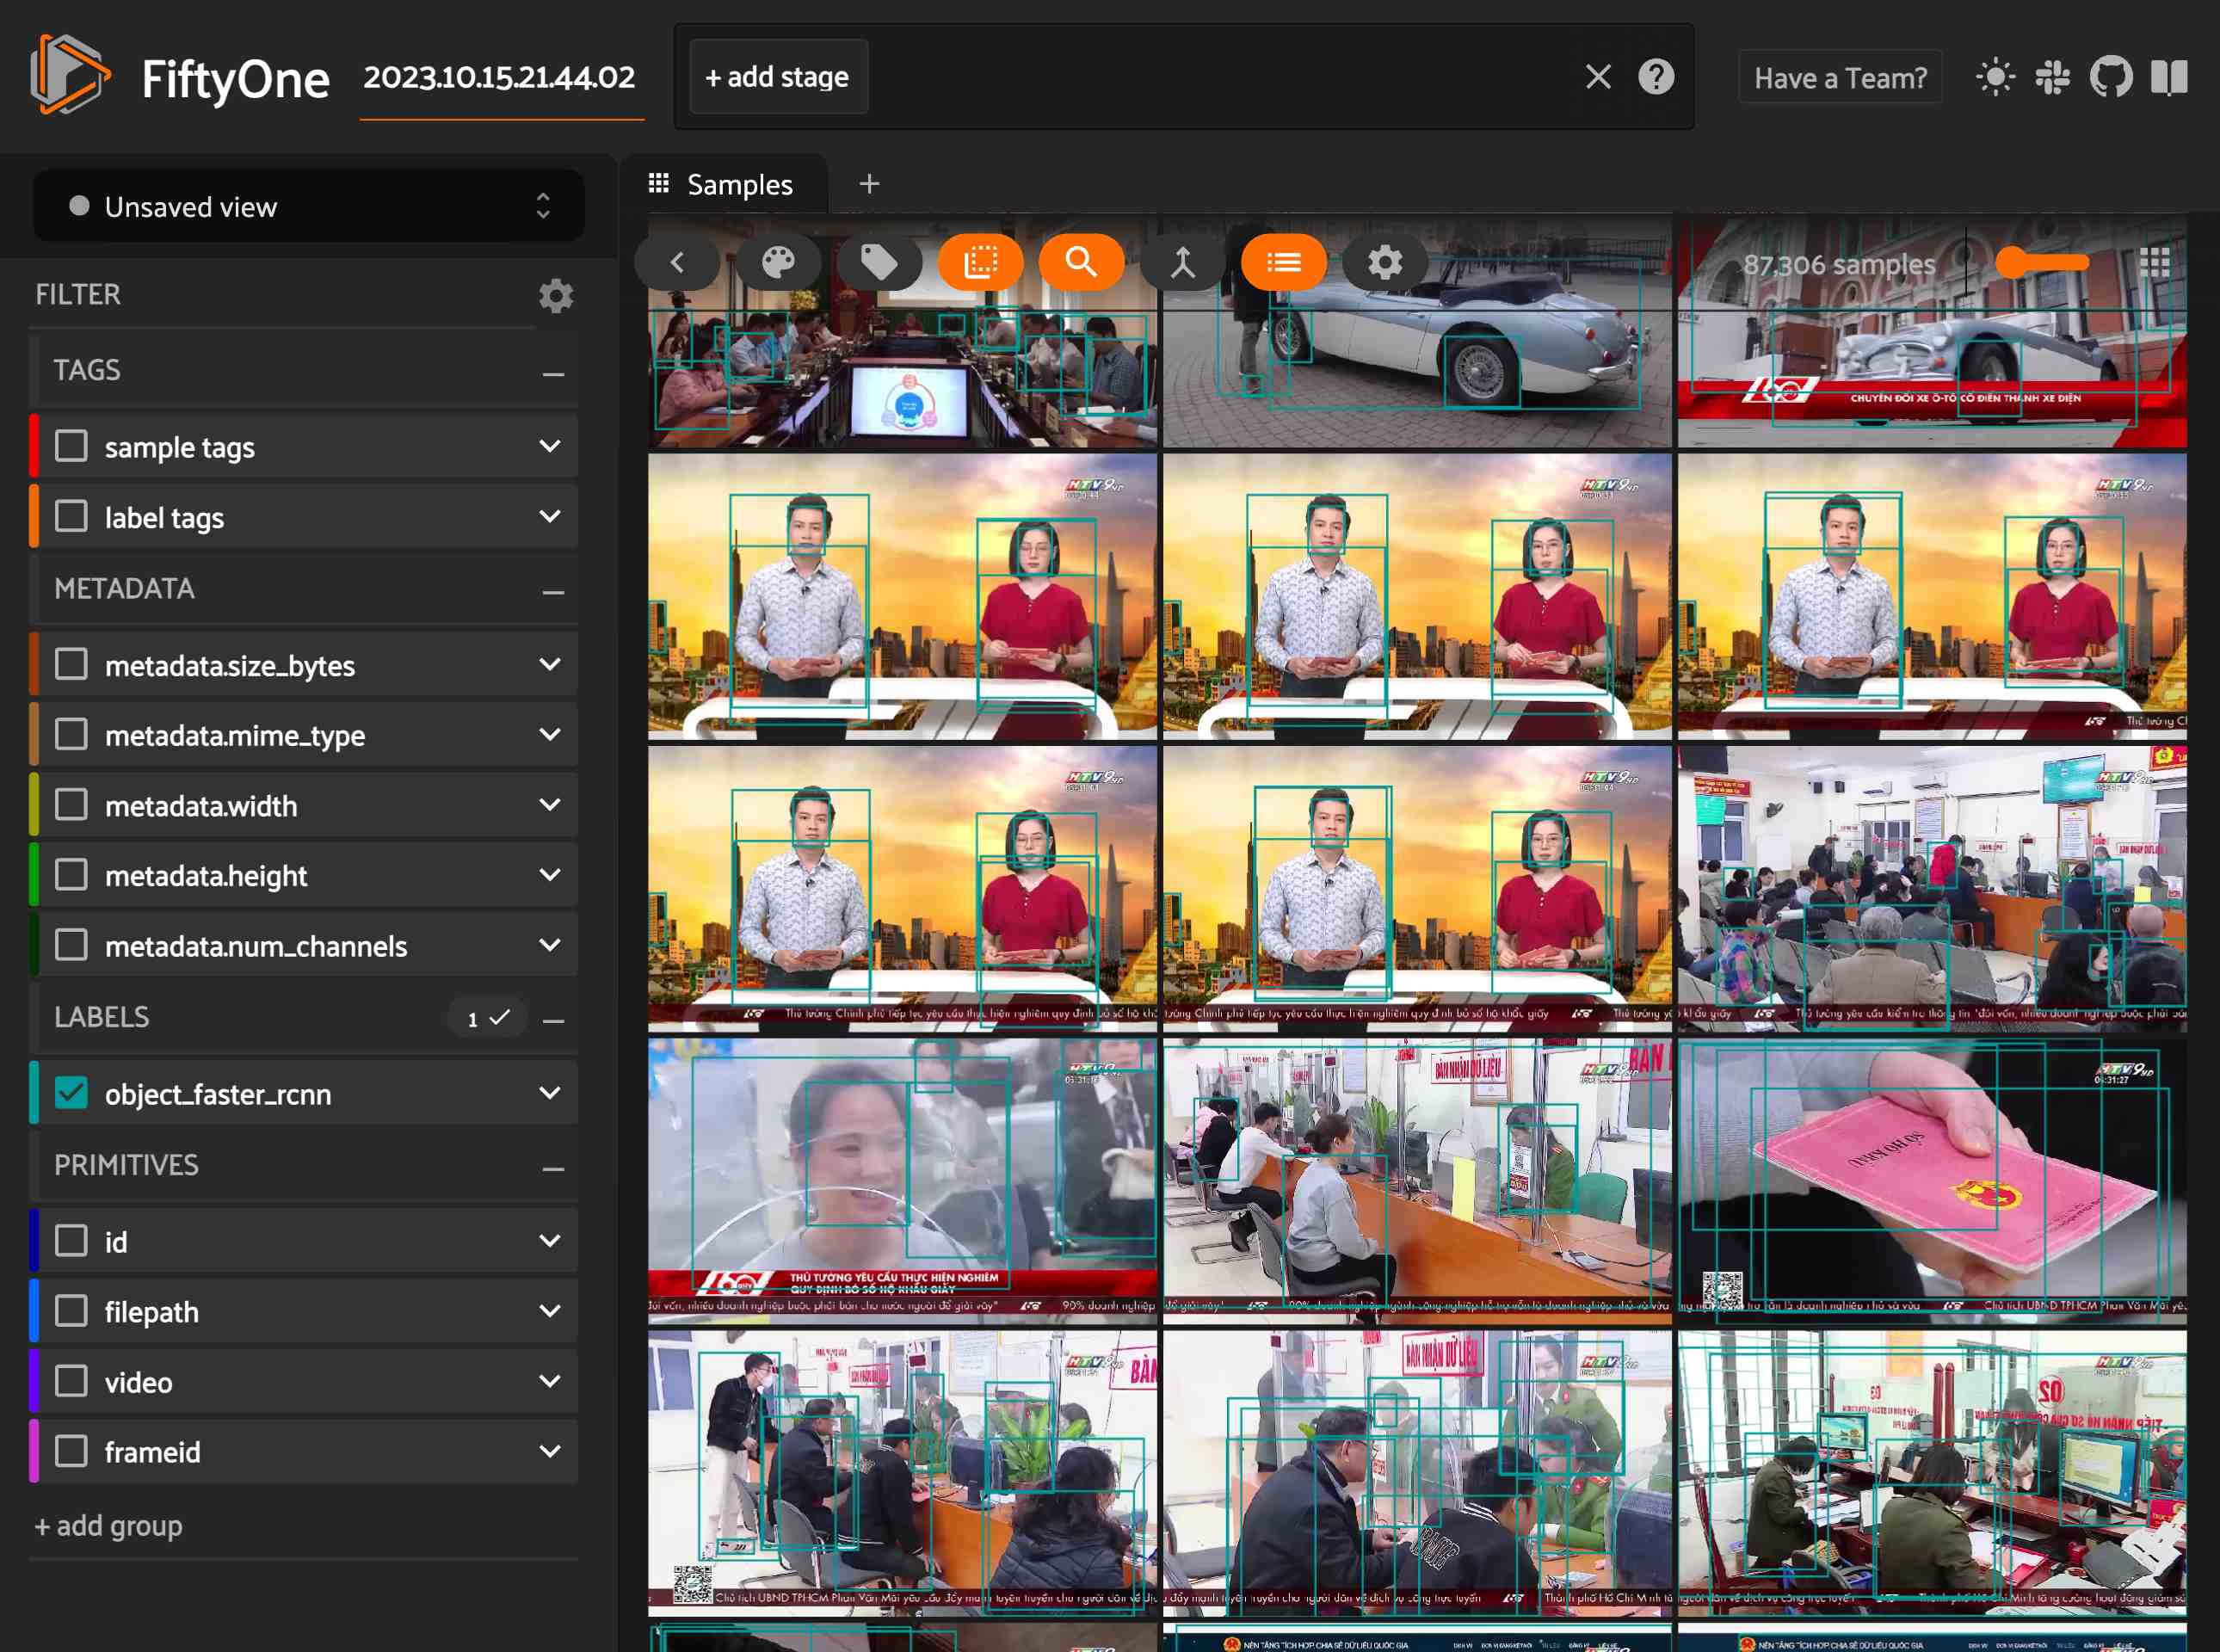


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



In [19]:
# start a session for show result of query below
session = fo.launch_app(dataset, port =5153)

In [ ]:
# # Query by vector
# query = np.random.rand(512)  # matches the dimension of CLIP embeddings
# view = dataset.sort_by_similarity(query, k=10, brain_key="milvus_index")
# session.view = view

In [ ]:
# # Query by sample ID
# query = dataset.first().id
# view = dataset.sort_by_similarity(query, k=10, brain_key="milvus_index")
# session.view = view

In [ ]:
# # Query by a list of IDs
# query = [dataset.first().id, dataset.last().id]
# view = dataset.sort_by_similarity(query, k=10, brain_key="milvus_index")
# session.view = view

In [23]:
# Query by text prompt
query = "picture has lotus"
view = dataset.sort_by_similarity(query, k=10, brain_key="milvus_index")
session.view = view


Could not connect session, trying again in 10 seconds




Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 s

In [ ]:
# print(milvus_index.collection)

# # The Milvus SDK is already initialized for you as well
# import pymilvus
# print(pymilvus.utility.list_collections())

### Thêm xoá dữ liệu

In [ ]:
# # Delete 10 samples from a dataset
# dataset.delete_samples(view)

# # Delete the corresponding vectors from the index
# milvus_index.remove_from_index(sample_ids=ids)

# # Add 20 samples to a dataset
# samples = [fo.Sample(filepath="tmp%d.jpg" % i) for i in range(20)]
# sample_ids = dataset.add_samples(samples)

# # Add corresponding embeddings to the index
# embeddings = np.random.rand(20, 512)
# milvus_index.add_to_index(embeddings, sample_ids)

# print(milvus_index.total_index_size)  # 210